*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Tomás Banduc

# **Laboratorio 4**

**Objetivo General:** Resolver problemas parabólicos multidimensionales mediante el método de Elementos Finitos.

**Objetivo Particular:** Se estudiará la resolución numérica del modelo de difusión dado por el núcleo de calor en 2-variedades con $\texttt{FEniCSx}$, resolviendo un problema de descomposición espectral dado por los valores y vectores propios del operador de Laplace-Beltrami.

In [ ]:
# importar gmsh

%%capture
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

In [ ]:
# importar dolfinx

%%capture
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [ ]:
# instalar e importar pyvista

!pip install pyvista
import pyvista as pv

In [ ]:
!pip install PyVirtualDisplay

In [ ]:
import pyvista as pv
from pyvirtualdisplay import Display
from dolfinx.plot import vtk_mesh

display = Display(visible=0, size=(600, 400))
display.start()

pv.OFF_SCREEN=False
pv.set_jupyter_backend("static")
pv.plotting.close_all()

True

In [ ]:
# sys
import sys

# gmsh
import gmsh

# ufl
import ufl

# MPI
from mpi4py import MPI

# dolfinx
import dolfinx.fem.petsc
from dolfinx.io import XDMFFile, distribute_entity_data, gmshio
from dolfinx import io, cpp, fem, mesh, plot

# PETSc
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType, Mat

# SLEPc
from slepc4py import SLEPc

# numpy
import numpy as np

# pyplot
import matplotlib.pyplot as plt
from matplotlib import cm

# time
import time

In [ ]:
comm = MPI.COMM_WORLD

## **Introducción**

En computación gráfica, los cuerpos geométricos son representados de manera discreta a través de nubes de puntos o mallados. Pese a que dichas representaciones son efectivas para visualización y renderizado de objetos multidimensionales, sus descriptores geométricos son insuficientes para comparar formas, clasificar figuras y detectar simetrías en ellas. En dicho contexto de aplicación, dos cuerpos son similares si existen transformaciones rígidas de uno en otro.

Dado lo anterior, resulta deseable que existan descriptores de superficies informativos, que sean de cómputo eficiente, invariantes frente a isometrías, que posean propiedades multi-escala y de estabilidad para pequeñas deformaciones en los cuerpos de estudio.

Las cualidades básicas requeridas para el análisis de formas las reúnen los procesos de difusión sobre variedades riemannianas compactas. Dicho proceso es caracterizado por el núcleo de calor inducido por el operador de Laplace-Beltrami.

### **Núcleo de Calor**

Sea $M$ una variedad riemanniana compacta. El modelo de difusión sobre $M$ para una distribución de calor inicial $u_0:M\to \mathbb{R}$ y condiciones Dirichlet homogéneas en su borde viene dado por:<br>
<br>
\begin{align}
  (H)\quad
  \begin{cases}
  -\Delta_M u + \partial_tu = 0&\text{en }M\times(0,T)\\
  u = 0 &\text{en }\partial M\times(0,T)\\
  u = u_0 &\text{en }M\times\{0\}
  \end{cases}
\end{align}<br>

Dichas soluciones son inducidas bajo integración por el núcleo de calor $k:\mathbb{R}^+\times M \times M\to \mathbb{R}$, que describe un modelo de difusión donde se aplica una carga infinita de calor en un punto durante una ventana de tiempo infinitesimalmente pequeña:<br>
<br>
\begin{align}
  (K)\quad
  \begin{cases}
  -\Delta_M k(t,x,y) + \partial_tk(t,x,y) = 0&(x,y,t)\in M\times M\times(0,T),\\
  k(t,x,y) = k(t,y,x) = 0 &(x,y,t)\in M\times \partial M\times(0,T),\\
  \lim\limits_{t\to 0}k(t,x,y) = \delta_x(y) &(x,y)\in M\times M,
  \end{cases}
\end{align}<br>
donde $\delta_x$ es la delta de Dirac para $x\in M$.

### **Descomposición Espectral del Núcleo de Calor**
Por teorema espectral, el operador laplaciano sujeto a condiciones de borde Dirichlet homogéneas induce una base ortonormal de $L^2(M)$ dada por sus funciones propias normalizadas $\{\phi_i\}_{i=0}^\infty$:<br>
<br>
\begin{align}
(E_i)\quad
\begin{cases}
-\Delta_M\phi_i=\lambda_i \phi_i& \text{en }M,\\
\phi_i =0&\text{en }\partial M,
\end{cases}
\end{align}<br>

donde $\{\lambda_i\}_{i=0}^\infty$ es una sucesión no-decreciente tal que $0<\lambda_0$ y $\lambda_i\to+\infty$.

Con esto, el núcleo de calor admite la siguiente descomposición:

\begin{align}
k(t,x,y)=\displaystyle\sum\limits_{i=0}^{\infty}e^{-t\lambda_i}\phi_i(x)\phi_i(y)
\end{align}

### **Problema de Valores Propios del Laplaciano con Elementos Finitos**

La formulación débil del problema $(E_i)$ viene dada por la búsqueda de $\phi_i\in H_0^1(M)$ y $\lambda_i\in\mathbb{R}^+$ tales que:<br>
<br>
\begin{align}
\begin{cases}
\displaystyle\int_M \nabla_M\phi_i\cdot\nabla_Mv = \lambda_i\displaystyle\int_M\phi_i v,\quad \forall v\in H_0^1(M)\\
\displaystyle\int_{M}\phi_i^2 = 1
\end{cases}
\end{align}<br>

Discretizando el problema con elementos finitos, se deduce el siguiente problema de valores propios generalizado:<br>
<br>
\begin{align}
(E_h)\quad\begin{cases}
A\vec{\phi}_i = \lambda_i B \vec{\phi}_i,\\
\vec{\phi}_i^TB\vec{\phi}_i=1
\end{cases}
\end{align}

donde $\vec{\phi}_i$ es un vector de coeficientes asociado a los grados de libertad dados por el espacio de aproximación de $H_0^1(M)$. La matriz de rigidez $A$ y matriz de masa $B$ vienen definidas según:<br>
<br>
\begin{align}
\begin{cases}
A_{ij}=\displaystyle\int_M \nabla_Mv_i\cdot\nabla_Mv_j,\\
B_{ij}= \displaystyle\int_M v_iv_j,
\end{cases}
\end{align}<br>
con $\{v_i\}_i$ correspondiente al espacio de elementos finitos de $H_0^1(M)$.


# **Parte I**

En esta sección se estimarán numéricamente las soluciones de valores propios del laplaciano sobre una 2-esfera. Para ello, se utilizará $\texttt{FEniCSx}$ y $\texttt{PETSc}$ en la resolución de un problema hermítico general correspondiente a su formulación por elementos finitos y $\texttt{Paraview}$ para la visualización de sus resultados.

### **P1**.
> Implemente una función ``create_sphere(r, c, Lmin, Lmax)`` que genere un mallado de $\texttt{DOLFINx}$ para una esfera de radio ``r`` y centro ``c``  con elementos triangulares y largos característicos ``Lmin``, ``Lmax``. Genere un dominio de esfera de radio $1$, centro $(0,0,0)$ y largos característicos $L_{min}=L_{max}=0.05$. Guarde su archivo correspondiente en formato ``.xdmf``.






In [ ]:
def create_sphere(r:float, c:tuple, Lmin:float, Lmax:float):

  gmsh.initialize()

  gdim = 3

  sphere = gmsh.model.occ.add_sphere(c[0], c[1], c[2], radius = r)
  gmsh.model.occ.synchronize()

  surf = gmsh.model.getEntities(dim = gdim - 1)
  tag = 1
  gmsh.model.addPhysicalGroup(dim = surf[0][0], tags = [surf[0][1]], tag = tag)

  gmsh.option.setNumber("Mesh.CharacteristicLengthMin", Lmin)
  gmsh.option.setNumber("Mesh.CharacteristicLengthMax", Lmax)
  gmsh.model.mesh.generate()

  gmsh_model_rank = 0
  mesh_comm = MPI.COMM_WORLD

  domain, cell_markers, facet_markers = gmshio.model_to_mesh(model = gmsh.model, comm = mesh_comm, rank = gmsh_model_rank, gdim = gdim)

  gmsh.finalize()

  return domain

In [ ]:
domain = create_sphere(1,(0,0,0),0.05,0.05)

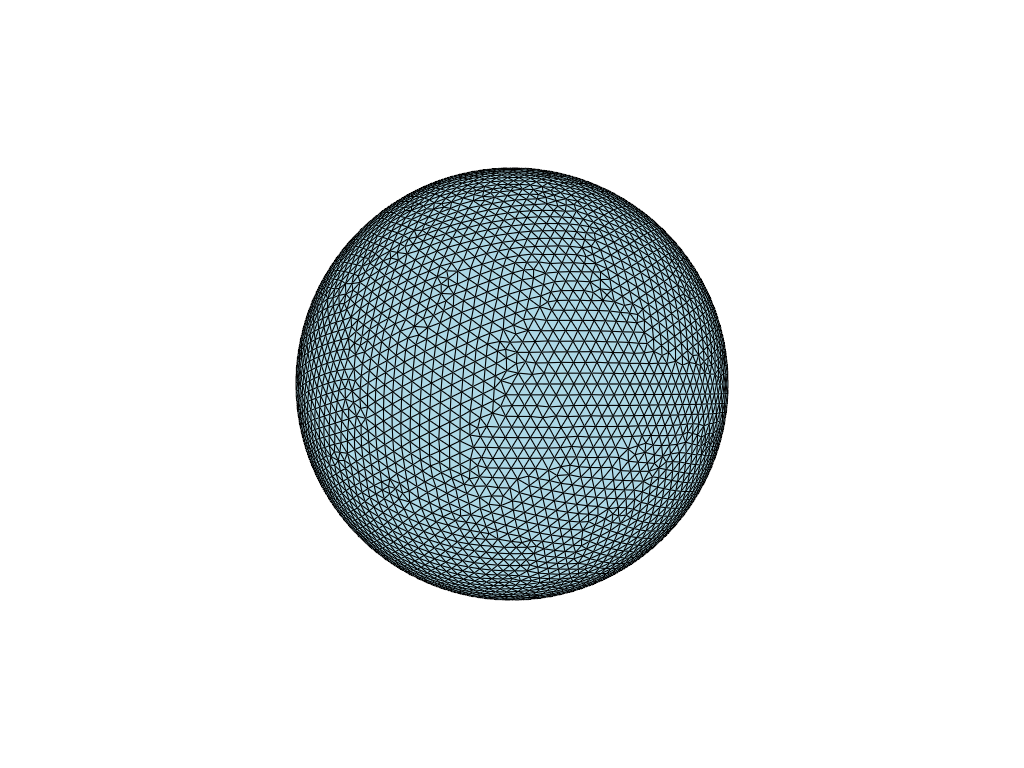

In [ ]:
pyvista_cells, cell_types, x = plot.vtk_mesh(domain) # obtener componentes de malla vtk
subplotter = pv.Plotter(shape = (1,1), notebook = True) # inicializar graficador

grid = pv.UnstructuredGrid(pyvista_cells, cell_types, x) # generar grid de pyvista

subplotter.subplot(0,0) # primer subplot
subplotter.add_mesh(grid, cmap = "rainbow", lighting = False, show_edges = True, show_scalar_bar = True) # agregar mallado
subplotter.view_xy() # visualizar solo plano xy

subplotter.show() # mostrar figura

In [ ]:
with dolfinx.io.XDMFFile(domain.comm, "deflection_solution.xdmf", "w") as xdmf:
  xdmf.write_mesh(domain) # guardar mallado

### **P2.**
> **(a)** Cree una función ``eigen_system(V)``, que reciba un espacio de funciones de dimensión finita ``V`` y retorne las matrices de rigidez y de masa asociadas al problema $(E_h)$. Luego, programe un método ``eigen_solve(A, B, num)``, que reciba una matriz de rigidez ``A``, una matriz de masa ``B`` y un entero ``num``, y retorne los ``num`` primeros valores y vectores propios asociados al problema generalizado $Ax=\lambda Bx$.

In [ ]:
def eigen_system(V:fem.function.FunctionSpace):

  u = ufl.TrialFunction(V)
  v = ufl.TestFunction(V)

  u_grad = ufl.grad(u)
  v_grad = ufl.grad(v)

  a = ufl.dot(u_grad,v_grad) * ufl.dx
  b = ufl.dot(u,v) * ufl.dx

  A, B = fem.petsc.assemble_matrix(fem.form(a)), fem.petsc.assemble_matrix(fem.form(b))

  A.assemble()
  B.assemble()

  PETSc.Mat.setOption(A,PETSc.Mat.Option.SYMMETRIC,True)
  PETSc.Mat.setOption(A,PETSc.Mat.Option.SYMMETRY_ETERNAL,True)

  PETSc.Mat.setOption(B,PETSc.Mat.Option.SYMMETRIC,True)
  PETSc.Mat.setOption(B,PETSc.Mat.Option.SYMMETRY_ETERNAL,True)

  return A, B

In [ ]:
def eigen_solve(A:PETSc.Mat, B:PETSc.Mat, num:int):

  eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
  eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP) # Seleccione el problema adecuado con SLEPc.EPS.ProblemType

  shift = SLEPc.ST().create(MPI.COMM_WORLD)
  shift.setType(SLEPc.ST.Type.SINVERT)
  shift.setShift(sys.float_info.epsilon)
  eigensolver.setST(shift)

  eigensolver.setWhichEigenpairs(eigensolver.Which.TARGET_MAGNITUDE) # Seleccione el crecimiento de valores propios con eigensolver.Which
  eigensolver.setDimensions(nev = num) # Fijar número de valores propios por calcular

  eigensolver.setOperators(A,B) # Definir operadores del problema Ax = lambda*Bx
  eigensolver.solve()

  evs = eigensolver.getConverged()
  print(f"Number of converged eigenpairs: {evs}. Taking first {num}.")

  eig_vecs = []
  eig_vals = []

  for i in range(num): # Extraer valores y vectores propios
    vr, vi = A.getVecs()
    l = eigensolver.getEigenpair(i, vr, vi)
    eig_vecs.append(vr.getArray().copy())
    eig_vals.append(l.real)

  eig_vecs = np.array(eig_vecs).T
  eig_vals= np.array(eig_vals)

  return eig_vecs, eig_vals

> **(b)** Resuelva el problema de los primeros $100$ valores propios del laplaciano sobre la 2-esfera. Grafique los valores únicos (aproximados) del arreglo que obtenga y estudie su crecimiento. Haga lo mismo para la multiplicidad de cada uno de dichos valores. Obtenga una fórmula explícita para el conjunto de valores propios en el caso continuo, incluyendo su multiplicidad.   

In [ ]:
V = fem.functionspace(domain, ("Lagrange", 1))
A, B = eigen_system(V)

In [ ]:
eig_vecs, eig_vals = eigen_solve(A, B, 100)

Number of converged eigenpairs: 122. Taking first 100.


Text(0.5, 0, 'Índice del valor propio')

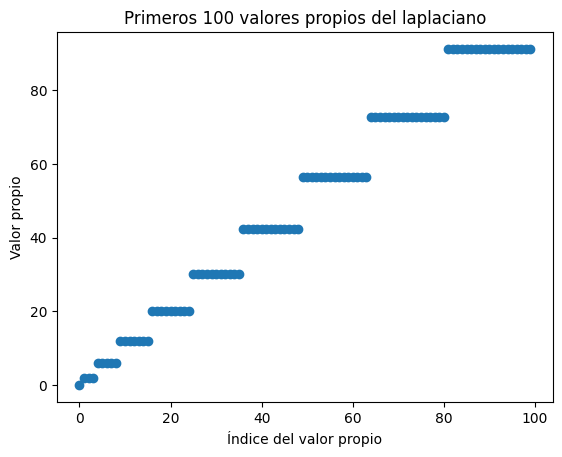

In [ ]:
plt.scatter(range(len(eig_vals)), eig_vals)
plt.title("Primeros 100 valores propios del laplaciano")
plt.ylabel("Valor propio")
plt.xlabel("Índice del valor propio")

In [ ]:
def filtrado(eig_vals):
  vals_filter = [eig_vals[0]]
  mult = [] #lista con la multiplicidad de cada v.p. distinto encontrado
  val_actual = eig_vals[0]
  contador = 1
  for val in eig_vals[1:]:
    if np.abs(val_actual - val) >= 1: #si hay una diferencia significativa, es otro v.p.
      val_actual = val
      vals_filter.append(val_actual)
      mult.append(contador)
      contador = 1
    else:
      contador += 1
  mult.append(contador)
  return np.array(vals_filter), np.array(mult)

In [ ]:
vals_filter, mult = filtrado(eig_vals)

In [ ]:
vals_filter

array([4.74335900e-15, 2.00120820e+00, 6.00725802e+00, 1.20254604e+01,
       2.00666437e+01, 3.01452949e+01, 4.22799236e+01, 5.64909697e+01,
       7.28050805e+01, 9.12531437e+01])

Text(0, 0.5, 'Valor propio')

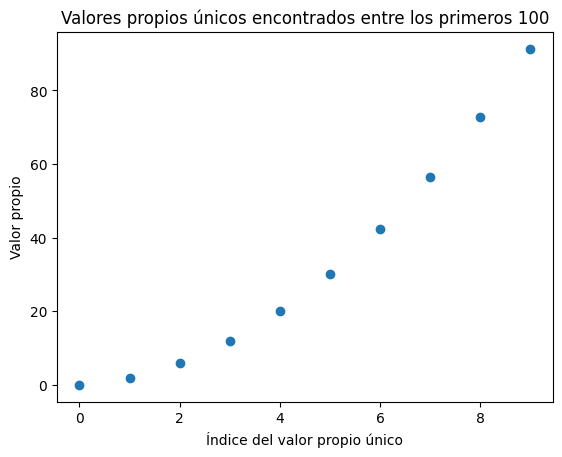

In [ ]:
plt.scatter(range(len(vals_filter)), vals_filter)
plt.title("Valores propios únicos encontrados entre los primeros 100")
plt.xlabel("Índice del valor propio único")
plt.ylabel("Valor propio")

Text(0, 0.5, 'Multiplicidad el valor propio')

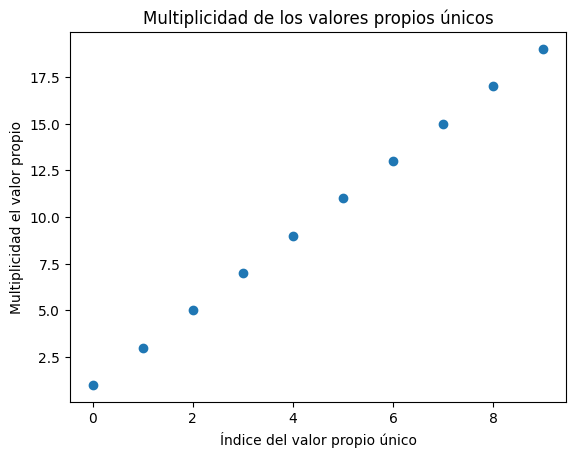

In [ ]:
plt.scatter(range(len(mult)), mult)
plt.title("Multiplicidad de los valores propios únicos")
plt.xlabel("Índice del valor propio único")
plt.ylabel("Multiplicidad el valor propio")

In [ ]:
# Usamos la función polyifit para hallar el polinomio que mejor aproxima los valores propios
# únicos encontrados para el caso continuo (notando que existe un comportamiento cudrático)
coefficients = np.polyfit(np.array([0,1,2,3,4,5,6,7,8,9]),vals_filter, 2)
a, b, c = coefficients

In [ ]:
print("La fórmula continua de los valores propios únicos es:\n v(k) = {}k^2 + {}k + {}".format(a,b,c))

La fórmula continua de los valores propios únicos es:
 v(k) = 1.0260200970006277k^2 + 0.8880373045957042k + 0.06975764923281473


In [ ]:
# En el caso de la multiplicidad se observa un comportamiento lineal, y los parametros
# a=2, b=1 calzan perfectamente los datos, con lo que el polyfit no es necesario
print(mult)
a_mult, b_mult = 2, 1

[ 1  3  5  7  9 11 13 15 17 19]


In [ ]:
print("La fórmula continua de la multiplicidad es:\n m(k) = {}k + {}".format(a_mult,b_mult))

La fórmula continua de la multiplicidad es:
 m(k) = 2k + 1


## **P3.**

> **(a)** Con las fórmulas deducidas del ítem anterior, grafique el error relativo de los valores propios calculados.

Text(0, 0.5, 'Error de la aproximación')

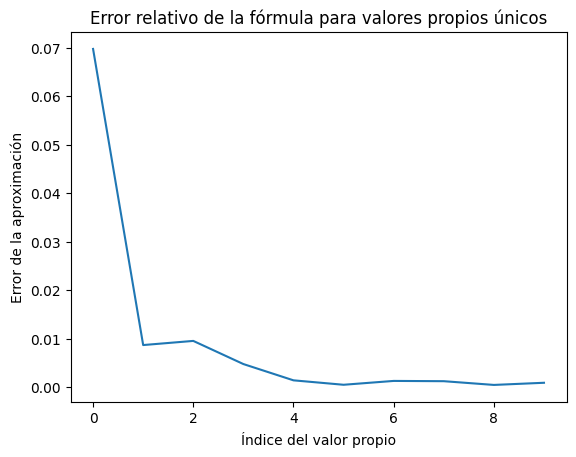

In [ ]:
def formula_val(k): #formula que aproxima los valores propios únicos usando los param. anteriores
  return a*k**2 + b*k + c

vals_aprox = [formula_val(k) for k in range(10)] #lista con los vals. propios aproximados
#calculamos el primer error a parte (no relativo) para no dividir por cero
error_0 = np.abs(vals_aprox[0] - vals_filter[0])
#calculamos los errores relativos para el resto de valores propios
error_cola = np.abs( (vals_aprox[1:] - vals_filter[1:])/vals_filter[1:] )
error = np.insert(error_cola, 0, error_0)
plt.plot(error)
plt.title("Error relativo de la fórmula para valores propios únicos")
plt.xlabel("Índice del valor propio")
plt.ylabel("Error de la aproximación")

> **(b)** Genere un archivo ``.xdmf`` que contenga para cada valor propio (salvo multiplicidad) una de sus funciones propias. <br>
<br> **Indicación:** Utilizando $\texttt{Paraview}$, haga capturas de cada una de las funciones propias evaluadas sobre la geometría. Use para ello ``Save Screenshot``. Comente sobre el comportamiento de dichas funciones con el incremento de los valores propios respectivos.

In [ ]:
def formula_multiplicidad(k):
  return 2*k+1

index = [sum(mult[:i+1]) -1 for i in range(len(mult))] #índices en los que cambian los valores propios
eig_vecs_filter = eig_vecs[:,index]

In [ ]:
with dolfinx.io.XDMFFile(domain.comm, "sphere_ev.xdmf", "w") as xdmf:
  xdmf.write_mesh(domain) # guardar mallado
  hk = fem.Function(V)
  hk.name = "hk"
  l = eig_vecs_filter.shape[1] #cantidad de vectores propios por guardar
  for i in range(l):
    hk.x.array[:] = eig_vecs_filter[:,i]
    t = i #asociamos cada vector propio a un tiempo correspondiente a su índice
    xdmf.write_function(hk, t = t) # t es una timestamp

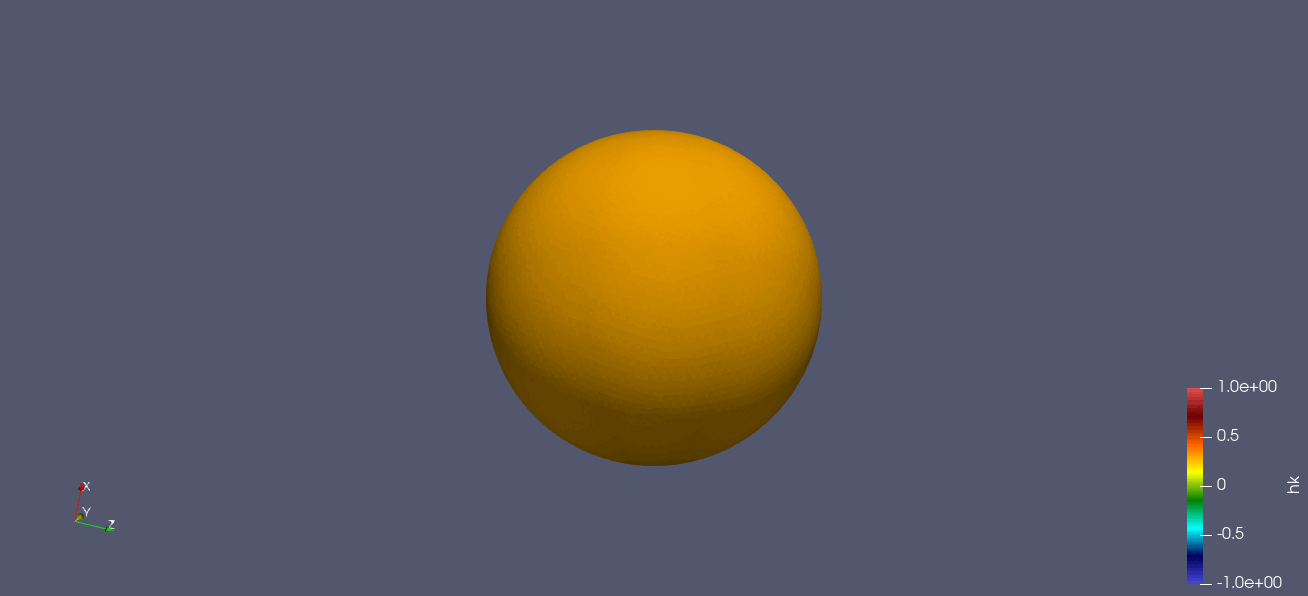

In [ ]:
from IPython.display import Image
Image(open('sphere_ev.gif','rb').read())

Se observa que la primera función propia gráficada es la trivial, la cual es constante en toda la esfera. Luego se observan funciones periódicas con patrones periódicos sobre la superficie. La frecuencia en dichos patrones aumenta junto con el valor propio gráficado, generando "manchas" cada vez mas numerosas y pequeñas.

# **Parte II**

En esta sección se estimará numéricamente el núcleo de calor sobre un mallado de armadillo, y se evaluará la capacidad de dicho kernel para caracterizar regiones específicas de su geometría.

## **P1**

> **(a)** Cargue el archivo de una figura de armadillo ``armadillo_0.xdmf`` en su sesión. Calcule y grafique los $100$ primeros valores propios del laplaciano sobre su superficie.

**Indicación:** Normalice la geometría antes de ejecutar las funciones para resolver el problema espectral.

**Indicación:** Comparando con los valores propios obtenidos para la 2-esfera, indique qué es lo que se puede esperar  generalmente de sus multiplicidades en cuerpos con pocas simetrías.

In [ ]:
 with io.XDMFFile(comm,"armadillo_0.xdmf","r") as xdmf:
  armadillo = xdmf.read_mesh(name="Grid")

In [ ]:
G = armadillo.geometry.x
uG = G.mean(axis=0)
dG = G.std(axis=0).max()
Gn = (G-uG)/dG


In [ ]:
armadillo.geometry.x[:] = Gn

In [ ]:
V1 = fem.functionspace(armadillo, ("Lagrange", 1))
A1, B1 = eigen_system(V1)
eig_vecs1, eig_vals1 = eigen_solve(A1, B1, 100)

Number of converged eigenpairs: 117. Taking first 100.


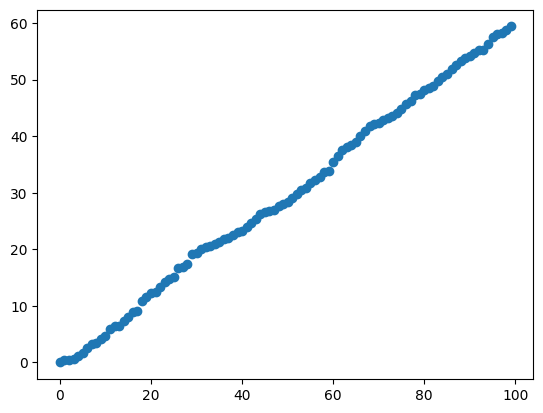

In [ ]:
plt.scatter(range(len(eig_vals1)), eig_vals1)

Comparando con lo obtenido con la 2-esfera, notamos que el armadillo es una geometría que no tiene simetría, y esto parece implicar que las multiplicidades son casi siempre 1, a diferencia de la 2-esfera. Los valores propios se tienden a desordenar.

> **(b)** Programe un método ``heat_kernel(eigvecs, eigvals, t_steps, source, scaling)``, que reciba un arreglo de vectores y valores propios ``eigvecs``, ``eigvals``, un número de pasos de tiempo ``t_steps``, el índice del punto asociado a un Dirac ``source`` y un booleano de escalamiento ``scaling``, y retorne el núcleo de calor con fuente en ``source`` según su descomposición espectral.<br>
<br>
**Indicación:** Haga sus cálculos omitiendo el primer valor propio.
<br>
**Indicación:** Cuando ``scaling`` sea verdadero, el núcleo de calor debe calcularse dividiendo por su traza, es decir:<br>
<br>
\begin{align}
k_N(t,x,y)=\left(\sum_\limits{i=1}^Ne^{-\lambda_it}\phi_i(x)\phi_i(y)\right)/\left(\sum\limits_{i=1}^N e^{-\lambda_it}\right)
\end{align}

In [ ]:
def heat_kernel(eigvals:np.ndarray, eigvecs:np.ndarray, t_steps:int, times:np.ndarray = None, source:int = 0, scaling:bool = False):

  if times is None:
    t_min  = 4 * np.log(10) / eigvals[-1] # lambda_{|eigvals|}
    t_max  = 4 * np.log(10) / eigvals[1] # lambda_{1}
    T = np.geomspace(t_min, t_max, t_steps)

  else:
    T = np.array(times).flatten()
    assert len(T) == t_steps

  phi = eigvecs[:, 1:]*eigvecs[source, 1:]
  exp = np.exp(-eigvals[1:, None]*T)
  k = np.sum(phi[..., None]*exp[None], axis=1)
  print(phi.shape)

  if scaling:
    norm = np.sum(exp[None], axis=1)
    k = k/norm

  return k,T

## **P2**

> Calcule el núcleo de calor normalizado para la figura de armadillo considerando los primeros $100$ valores y vectores propios del laplaciano, para una fuente ubicada en la punta de la nariz del armadillo. Guarde el archivo ``.xdmf`` correspondiente. <br>
<br>
**Indicación:** Para ubicar la región solicitada, utilice el selector ``Select Points On`` de Paraview para encontrar un ID de punto que le sea de utilidad.<br>
**Indicación:** Usando ``Save Animation`` en Paraview, obtenga una secuencia de fotogramas de evolución de la función, y cree un GIF con ella.

In [ ]:
k, T = heat_kernel(eig_vals1, eig_vecs1, 50, None, 66779, True)

(165954, 99)


In [ ]:
k.shape

(165954, 50)

In [ ]:
hk = fem.Function(V1)

In [ ]:
with dolfinx.io.XDMFFile(armadillo.comm, "armadillo_kernel.xdmf", "w") as xdmf:
  xdmf.write_mesh(armadillo) # guardar mallado
  hk = fem.Function(V1)
  hk.name = "hk"
  for i in range(T.shape[0]):
    hk.x.array[:] = k[:,i]
    t = T[i]
    xdmf.write_function(hk, t = t) # t es una timestamp

## **P3**

> **(a)** Implemente una función ``heat_kernel_point(eigvals, eigvecs, t_steps, source, target, scaling)`` que haga lo mismo que el método de la pregunta anterior, pero que solo evalúe la concentración de calor en un nodo ``target`` especificado.

In [ ]:
def heat_kernel_point(eigvals, eigvecs, t_steps, times = None, source = 0, target = 0, scaling = False):

  if times is None:
    t_min  = 4 * np.log(10) / eigvals[-1]
    t_max  = 4 * np.log(10) / eigvals[1]
    T = np.geomspace(t_min, t_max, t_steps)

  else:
    T = np.array(times).flatten()
    assert len(T) == t_steps

  phi = eigvecs[target, 1:]*eigvecs[source, 1:]
  exp = np.exp(-eigvals[1:, None]*T)
  k = np.sum(phi[..., None]*exp[None], axis=1)

  if scaling:
    norm = np.sum(exp[None], axis=1)
    k = k/norm

  return k,T

In [ ]:
k1, T1 = heat_kernel_point(eig_vals1, eig_vecs1, 50, None, 66779, 100000, True) #testeando

> **(b)** Seleccione un nodo en la punta de algún dedo de la pata superior izquierda del armadillo, otro de un dedo en su pata superior derecha y otro en la punta de un dedo de alguna de sus patas inferiores, graficando en cada caso el núcleo de calor considerando el mismo punto como fuente y como *target*.<br>
<br>**Indicación:** Refiérase al comportamiento local y global del kernel estudiado. Adicionalmente, comente respecto de la estabilidad del núcleo de calor y si se puede utilizar para caracterizar transformaciones isométricas de una figura.<br>
**Hint:** Puede guiarse de los contenidos de las páginas 3 y 4 de la siguiente referencia https://www.lix.polytechnique.fr/~maks/papers/hks.pdf.


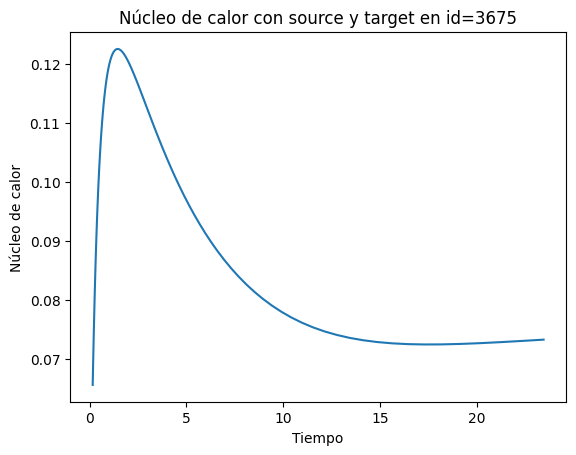

In [ ]:
#coordenadas de puntos:

id_dedo_pata_superior_izq = 3675 #meñique

k, T = heat_kernel_point(eig_vals1, eig_vecs1, 100, None, 3675, 3675, True)
plt.plot(T,k[0])
plt.xlabel('Tiempo')
plt.ylabel('Núcleo de calor')

# displaying the title
plt.title("Núcleo de calor con source y target en id=3675")

plt.show()


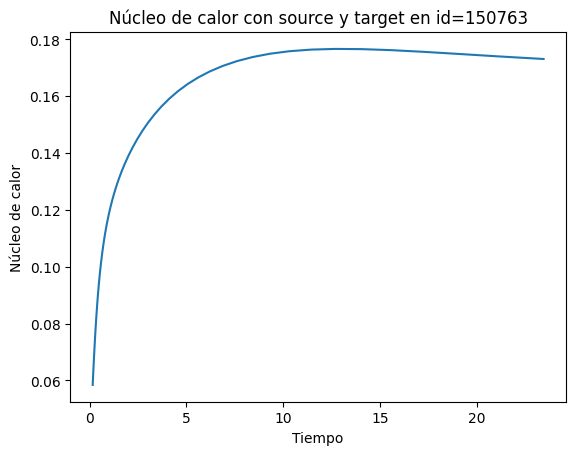

In [ ]:
id_dedo_pata_superior_der = 150763 #pulgar

k, T = heat_kernel_point(eig_vals1, eig_vecs1, 50, None, 150763, 150763, True)
plt.plot(T,k[0])
plt.xlabel('Tiempo')
plt.ylabel('Núcleo de calor')

# displaying the title
plt.title("Núcleo de calor con source y target en id=150763")

plt.show()

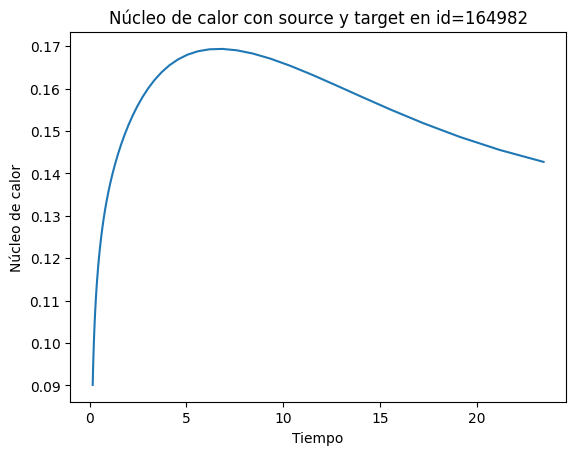

In [ ]:
id_dedo_pata_inferior = 164982 #pata izq
k, T = heat_kernel_point(eig_vals1, eig_vecs1, 50, None, 164982, 164982, True)
plt.plot(T,k[0])
plt.xlabel('Tiempo')
plt.ylabel('Núcleo de calor')

# displaying the title
plt.title("Núcleo de calor con source y target en id=164982")

plt.show()

Como bien menciona la fuente antes mencionada, si observamos en todo el armadillo el gráfico (como en el gif) la evolución a través del tiempo, podemos observar un comportamiento global en función del tiempo, es decir, a medida que transcurre el tiempo podemos ver como se distribuye el calor a toda la geometría del dominio y de qué forma.

Vemos que de manera local, podemos observar que el núcleo de calor tiende a tener un "peak" al que llega rapidamente para luego decrecer. Este comportamiento también se tenía cuando estudiamos el núcleo de calor en grafos.

Se tiene también que el Heat Kernel es estable respecto a perturbaciones en la geometría estudiada, lo que se debe a que el núcleo de calor corresponde a un promedio ponderado de todos los caminos por los que puede recorrer el calor desde un cierto source, lo que no cambia tanto si perturbamos ligeramente el dominio.

Además, el Kernel otorga condiciones para que toda función sobreyectiva en el dominio se pueda verificar si es isometría o no, esto dado porque el núcleo de calor almacena toda la información de la geometría del dominio, es decir, la caracteriza.